# Chest cancer detector

### Import libs

In [3]:
from glob import glob
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D ,MaxPooling2D , Flatten,Dense,Dropout,BatchNormalization
import cv2
from keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
from tensorflow.keras.optimizers import Adam, Adamax



### load Training and Validation Datasets


In [4]:
normal_case_train_dir='chest_xray/train/NORMAL'
pneumonia_case_train_dir="chest_xray/train/PNEUMONIA"
normal_case_val_dir="chest_xray/val/NORMAL"
pneumonia_case_val_dir="chest_xray/val/PNEUMONIA"
normal_case_test_dir="chest_xray/test/NORMAL"
pneumonia_case_test_dir="chest_xray/test/PNEUMONIA"

In [5]:
def create_df (normal_dir,pneumonia_dir):
    normal=os.listdir(normal_dir)
    normal_list=[]
    for i in normal:
        normal_list.append(os.path.join(normal_dir,i))
    pneumonia=os.listdir(pneumonia_dir)
    pneumonia_list=[]
    for i in pneumonia:
        pneumonia_list.append(os.path.join(pneumonia_dir,i))
    normal_list=list(zip(normal_list,[0]*len(normal_list)))
    pneumonia_list=list(zip(pneumonia_list,[1]*len(pneumonia_list)))
    total_data=normal_list + pneumonia_list
    df=pd.DataFrame(total_data,columns=['image','label'])
    return df

    

In [6]:
train_df=create_df(normal_case_train_dir,pneumonia_case_train_dir)
val_df=create_df(normal_case_val_dir,pneumonia_case_val_dir)
test_df=create_df(normal_case_test_dir,pneumonia_case_test_dir)

In [7]:
train_df.head()

,image,label
0,chest_xray/train/NORMAL\IM-0115-0001.jpeg,0
1,chest_xray/train/NORMAL\IM-0117-0001.jpeg,0
2,chest_xray/train/NORMAL\IM-0119-0001.jpeg,0
3,chest_xray/train/NORMAL\IM-0122-0001.jpeg,0
4,chest_xray/train/NORMAL\IM-0125-0001.jpeg,0


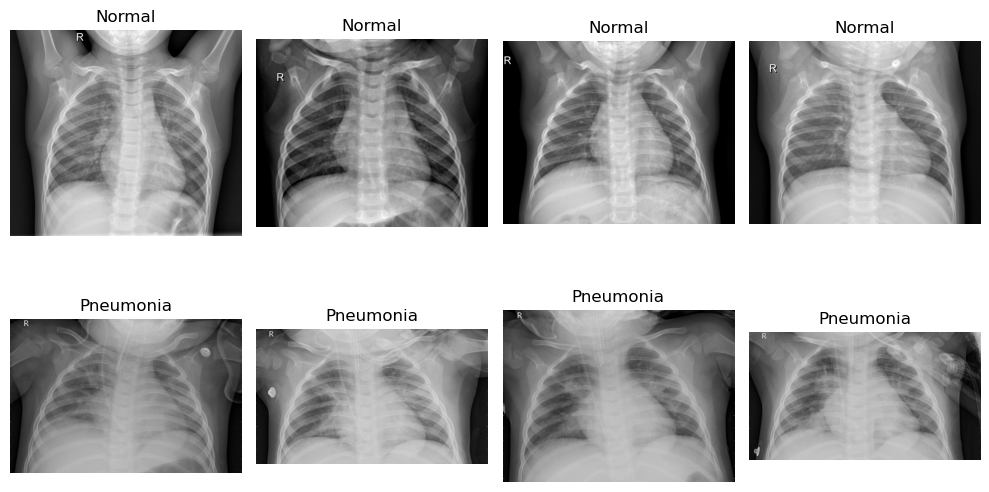

In [8]:
fig, ax=plt.subplots(2,4,figsize=(10,6))
labels = ['Normal', 'Pneumonia']

for i in range(4):
    ax[0,i].imshow(plt.imread(train_df['image'][i]), cmap='gray')
    ax[0, i].axis('off')
    ax[0, i].set_title('Normal')

    ax[1, i].imshow(plt.imread(train_df['image'][len(train_df['image']) - i-1]), cmap='gray')
    ax[1, i].axis('off')
    ax[1, i].set_title('Pneumonia')


plt.tight_layout()
plt.show()

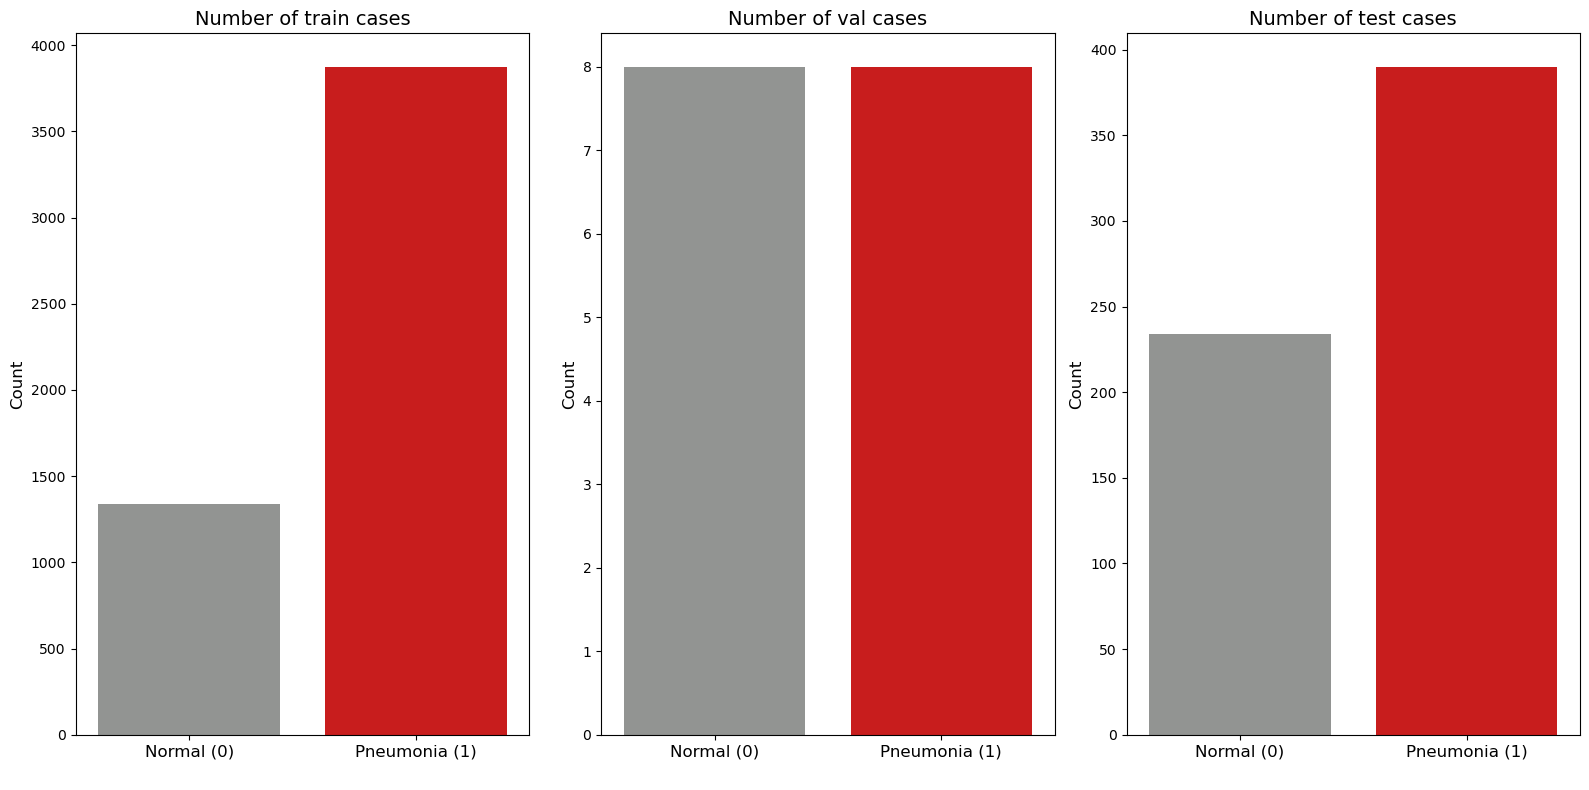

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
train_cases_count = train_df['label'].value_counts().sort_index()
test_cases_count = test_df['label'].value_counts().sort_index()
val_cases_count = val_df['label'].value_counts().sort_index()
palette = ['#929591','#e50000']
sns.barplot(x=train_cases_count.index, y=train_cases_count.values, ax=ax1,palette=palette)
ax1.set_title('Number of train cases', fontsize=14)

ax1.set_xlabel(' ', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Normal (0)', 'Pneumonia (1)'], fontsize=12)

sns.barplot(x=test_cases_count.index, y=test_cases_count.values, ax=ax3,palette=palette)
ax3.set_title('Number of test cases', fontsize=14)
ax3.set_xlabel(' ', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_xticks([0, 1])
ax3.set_xticklabels(['Normal (0)', 'Pneumonia (1)'], fontsize=12)


sns.barplot(x=val_cases_count.index, y=val_cases_count.values, ax=ax2,palette=palette)
ax2.set_title('Number of val cases', fontsize=14)
ax2.set_xlabel(' ', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Normal (0)', 'Pneumonia (1)'], fontsize=12)

plt.tight_layout()
plt.show()

### Image preprocessing

In [10]:
def images_to_numpy_array(image_path):

    image_arrays = []

    for path in image_path:
        image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        resized_image = cv2.resize(image,(128,128))
        image_arrays.append(resized_image)

    return image_arrays


In [11]:
train_df=train_df.sample(frac=1,random_state=42)
val_df=val_df.sample(frac=1,random_state=42)
test_df=test_df.sample(frac=1,random_state=42)
train_data=images_to_numpy_array(train_df['image'])
test_data=images_to_numpy_array(test_df['image'])
val_data=images_to_numpy_array(val_df['image'])
train_data=np.array(train_data) /255
val_data=np.array(val_data) /255
test_data=np.array(test_data) /255
#train_data.reshape(-1,128,128,1)
#val_data.reshape(-1,128,128,1)
#test_data.reshape(-1,128,128,1)
train_label=train_df['label'].to_numpy()
val_label=val_df['label'].to_numpy()
test_label=test_df['label'].to_numpy()


In [12]:
val_data

array([[[0.00392157, 0.04313725, 0.09411765, ..., 0.37254902,
         0.30588235, 0.24313725],
        [0.90196078, 0.04313725, 0.08627451, ..., 0.34509804,
         0.3254902 , 0.2627451 ],
        [0.00392157, 0.03529412, 0.07058824, ..., 0.30588235,
         0.29411765, 0.24313725],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.00784314, 0.40784314, 0.35686275, ..., 0.        ,
         0.        , 0.03921569],
        [0.00392157, 0.27843137, 0.36078431, ..., 0.        ,
         0.        , 0.04313725],
        [0.5372549 , 0.45098039, 0.29019608, ..., 0.02352941,
         0.05098039, 0.12941176],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [13]:
#os.makedirs('Chest cancer/preview/train_datagen')
#datagen= ImageDataGenerator(
#    rotation_range=40,
#    width_shift_range=.2,
#    zoom_range=.2,
#    shear_range=.2,
#    horizontal_flip=True,
#    fill_mode='nearest'
#)
#for i in range(0,len(train_df['image'])):
#    img_path=load_img(train_df['image'][i])
#    x = img_to_array(img_path)
#    x=x.reshape((1,)+x.shape)
#    i=0
#    for batch in datagen.flow(x,
#                              batch_size=1,
#                              save_to_dir='Chest cancer/preview/train_datagen',
#                              save_prefix='chest',
#                              save_format='jpeg'):
#        i+=1
#        if i>=5:
#            break


### Model

In [14]:
model=Sequential()
model.add(Conv2D(64,kernel_size=(5,5),input_shape=(128,128,1),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(.2))

model.add(Conv2D(64,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(.2))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(.2))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(.2))


model.add(Flatten())

model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 29, 29, 64)       

In [15]:
model.compile(optimizer = Adamax(learning_rate= 0.001) , loss = 'binary_crossentropy' , metrics = ['accuracy'])


In [16]:
history=model.fit(train_data, train_label, batch_size=32, epochs=10, validation_data=(test_data, test_label))


Epoch 1/10


163/163 [==============================] - 53s 315ms/step - loss: 0.5459 - accuracy: 0.7454 - val_loss: 0.5398 - val_accuracy: 0.6731
Epoch 2/10
163/163 [==============================] - 53s 323ms/step - loss: 0.3606 - accuracy: 0.8359 - val_loss: 0.3999 - val_accuracy: 0.8333
Epoch 3/10
163/163 [==============================] - 56s 342ms/step - loss: 0.2800 - accuracy: 0.8827 - val_loss: 0.3739 - val_accuracy: 0.8285
Epoch 4/10
163/163 [==============================] - 56s 341ms/step - loss: 0.2242 - accuracy: 0.9099 - val_loss: 0.4284 - val_accuracy: 0.8061
Epoch 5/10
163/163 [==============================] - 55s 336ms/step - loss: 0.2035 - accuracy: 0.9166 - val_loss: 0.4026 - val_accuracy: 0.8125
Epoch 6/10
163/163 [==============================] - 66s 407ms/step - loss: 0.1851 - accuracy: 0.9317 - val_loss: 0.3882 - val_accuracy: 0.8317
Epoch 7/10
163/163 [==============================] - 94s 575ms/step - loss: 0.1689 - accuracy: 0.9325 - val_loss: 0.3912 - val_

1/1 [==============================] - 0s 212ms/step - loss: 0.4469 - accuracy: 0.6875
Accuracy of our model on test data :  68.75 %


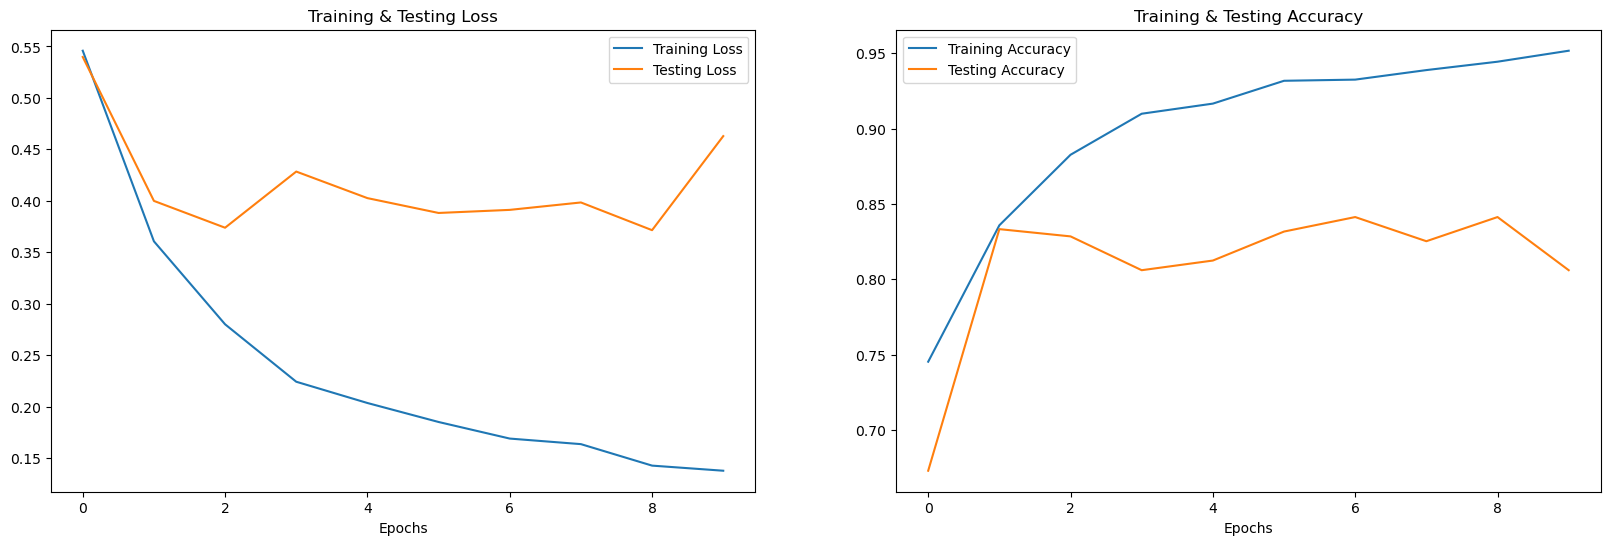

In [17]:
print("Accuracy of our model on test data : " , model.evaluate(val_data,val_label)[1]*100 , "%")

epochs = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()